# CSD 2: Exploratory Data Analysis

1. For this Case Study assignment you should have in your current folder the ebay_boys_girls_shirts folder, holding the four CSV files describing the train and test shirts images, and the boys and girls images folders. This is what we did in CSD 1, **if you already have the data in your current folder you don't need to run this again!**:

In [1]:
import requests
import tarfile

url = "http://www.tau.ac.il/~saharon/DScourse/ebay_boys_girls_shirts.tar.gz"
r = requests.get(url)

with open("../../datasets/ebay_boys_girls_shirts.tar", "wb") as file:
    file.write(r.content)

with tarfile.open("../../datasets/ebay_boys_girls_shirts.tar") as tar:
    tar.extractall('../../datasets/')

2. Let's look at some of the images in the training set. In order to see boys vs. girls shirts, we'll display a random group from each folder, side by side.

Let's get the metadata CSV files first as `pandas` DataFrames:

In [1]:
import pandas as pd

folder = 'ebay_boys_girls_shirts/'
boys_train_df = pd.read_csv(folder + 'boys_train.csv')
girls_train_df = pd.read_csv(folder + 'girls_train.csv')

3. Get a random sample of 400 image files from each folder, completing the following function:

In [2]:
def get_file_list(df, folder, n_sample = None, seed = None):
    if n_sample is None:
        file_ids_list = df.file_id.values
    else:
        file_ids_list = df.sample(n = n_sample, random_state = seed).file_id.values
    files_list = [folder + '/' + str(file_id) + '.jpg' for file_id in file_ids_list]
    return files_list

boys_display_files = get_file_list(boys_train_df, folder + 'boys', 400)
girls_display_files = get_file_list(girls_train_df, folder + 'girls', 400)
print(boys_display_files[:5])

['ebay_boys_girls_shirts/boys/11239.jpg', 'ebay_boys_girls_shirts/boys/15229.jpg', 'ebay_boys_girls_shirts/boys/5525.jpg', 'ebay_boys_girls_shirts/boys/15816.jpg', 'ebay_boys_girls_shirts/boys/4624.jpg']


4. Next we want to read each batch of random images as a 4D `numpy` array. Why 4D? That's [N images X height X width X N color channels], where in our case `N color channels` is 3 (Red, Green and Blue).

The function `read_image_and_resize` takes an image file address `f`, reads it with the standard [matplotlib](https://matplotlib.org/) library, `resize`s it to the given width and height in pixels (we use 100 for both) with the [skimage](http://scikit-image.org/docs/dev/api/skimage.html) library, and makes sure it is a 4D array, the size of `[1, 100, 100, 3]`:

In [3]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform, color, img_as_ubyte

%matplotlib inline

def read_image_and_resize(f, w = 100, h = 100):
    img = plt.imread(f)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        img = transform.resize(img, (w, h), mode='constant')
        img = img_as_ubyte(img)
    img = color.gray2rgb(img)
    img = img[np.newaxis, :, :, :3]
    if img.shape != (1, 100, 100, 3):
        raise ValueError(f + str(img.shape))
    return img

5. Complete the `read_images_4d_array` function which receives for boys and for girls our list of random images files and returns the final 4D array.

First create the list of single 4D arrays called `images_list`. Then lookup [numpy](http://www.numpy.org/) documentation (or wherever you want) to see the proper numpy function to "glue" the list of arrays into a single array called `images_array`.

In [4]:
def read_images_4d_array(files_list):
    images_list = [read_image_and_resize(file)
        for file in files_list]
    images_array = np.concatenate(images_list)
    return images_array

6. Your final arrays for boys and for girls should be of dimensions:

In [5]:
boys_display_images = read_images_4d_array(boys_display_files)
girls_display_images = read_images_4d_array(girls_display_files)
print(boys_display_images.shape)

(400, 100, 100, 3)


And of type:

In [6]:
print(boys_display_images.dtype)

uint8


What is their size on disk? You can check the size of an object in python in bytes like this:

In [7]:
import sys

sys.getsizeof(boys_display_images)

12000144

Read about [numpy types](https://www.numpy.org/devdocs/user/basics.types.html). See that you get why we got 120M bytes or 12MB.

Hint:

In [8]:
print(boys_display_images.itemsize)

1


7. The function `merge_images` will take our 4D images numpy array of 400 images and make it a 20x20 grid of sub-images. Complete the code to display two grids of boys and girls shirts side by side, as you see below:

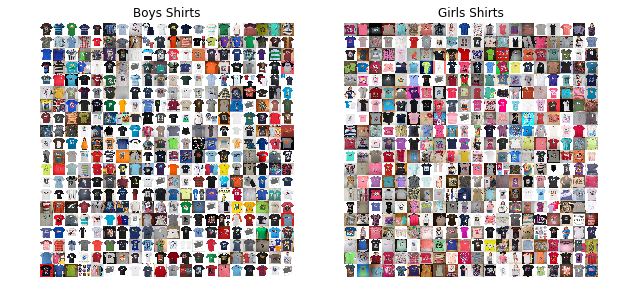

In [9]:
def merge_images(image_batch, size = [20, 20]):
    h,w = image_batch.shape[1], image_batch.shape[2]
    c = image_batch.shape[3]
    img = np.zeros((int(h*size[0]), w*size[1], c))
    for idx, im in enumerate(image_batch):
        i = idx % size[1]
        j = idx // size[1]
        img[j*h:j*h+h, i*w:i*w+w,:] = im/255 #notice we divide by 255 to get 0-1 float range
    return img

boys_merged = merge_images(boys_display_images)
girls_merged = merge_images(girls_display_images)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('Boys Shirts')
plt.axis('off')
plt.imshow(boys_merged)

plt.subplot(1, 2, 2)
plt.title('Girls Shirts')
plt.axis('off')
plt.imshow(girls_merged)

What would you say is the most obvious difference between boys and girls shirts images?

8. Let's look at the color histograms for the RGB channels for our images:

You'll need to know:

(a) how to flatten a N-D numpy array:

In [10]:
a = np.array([[[1, 2], [3, 4]], [[5, 6], [7, 8]]])
print(a)
print()
print(a.shape)
print()
print(a[:, :, 0])
print()
print(a[:, :, 0].flatten())

[[[1 2]
  [3 4]]

 [[5 6]
  [7 8]]]

(2, 2, 2)

[[1 3]
 [5 7]]

[1 3 5 7]


(b) plot a weighted histogram:

(array([ 0.07,  0.13,  0.08,  0.11,  0.14,  0.08,  0.11,  0.1 ,  0.07,  0.11]),
 array([ 0.01715515,  0.1147449 ,  0.21233465,  0.30992439,  0.40751414,
         0.50510388,  0.60269363,  0.70028337,  0.79787312,  0.89546286,
         0.99305261]),
 <a list of 10 Patch objects>)

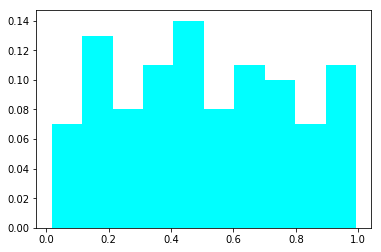

In [11]:
a = np.random.rand(100)
plt.hist(a, weights = np.ones_like(a) / len(a), color = "cyan")

Complete the `plot_hist_normed` function to see all color histograms for boys and girls shirts images. See the function usage below for more hints regarding its expected input:

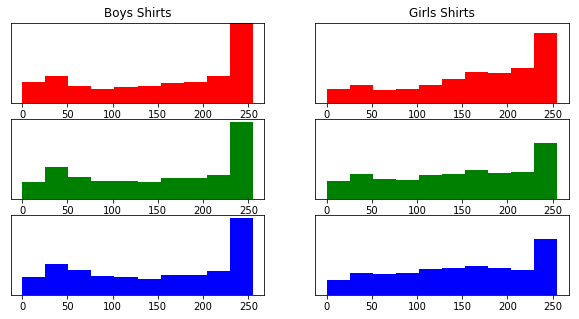

In [12]:
def plot_hist_normed(images, channel, col):
    vals = images[:, :, :, channel].flatten()
    plt.hist(vals, weights = np.ones_like(vals) / len(vals), color = col)
    plt.ylim([0, 0.3])
    plt.yticks([])
    
plt.figure(figsize =(10, 5))
plt.subplot(3, 2, 1)
plot_hist_normed(boys_display_images, 0, 'red')
plt.title('Boys Shirts')
plt.subplot(3, 2, 2)
plot_hist_normed(girls_display_images, 0, 'red')
plt.title('Girls Shirts')
plt.subplot(3, 2, 3)
plot_hist_normed(boys_display_images, 1, 'green')
plt.subplot(3, 2, 4)
plot_hist_normed(girls_display_images, 1, 'green')
plt.subplot(3, 2, 5)
plot_hist_normed(boys_display_images, 2, 'blue')
plt.subplot(3, 2, 6)
plot_hist_normed(girls_display_images, 2, 'blue')
plt.show()

What would you say is the most obvious difference between boys and girls shirts images?

9. See the channels mean and median verify your "feelings". Also print out the share of pixels above say 220:

In [13]:
def summary(images, channel, col):
    vals = (images[:, :, :, channel]).flatten()
    print('  %s mean: %.2f, median: %.2f, share above 220: %.2f' % (col, np.mean(vals), np.median(vals), np.mean(vals > 0.9)))

print('Boys:')
summary(boys_display_images, 0, 'red')
summary(boys_display_images, 1, 'green')
summary(boys_display_images, 2, 'blue')
print('Girls:')
summary(girls_display_images, 0, 'red')
summary(girls_display_images, 1, 'green')
summary(girls_display_images, 2, 'blue')

Boys:
  red mean: 160.05, median: 180.00, share above 220: 1.00
  green mean: 153.08, median: 164.00, share above 220: 1.00
  blue mean: 152.15, median: 163.00, share above 220: 1.00
Girls:
  red mean: 165.48, median: 180.00, share above 220: 1.00
  green mean: 149.30, median: 157.00, share above 220: 1.00
  blue mean: 149.99, median: 155.00, share above 220: 1.00
